## ⏹ Importing the required libraries:

In [1]:
import pandas as pd
import matplotlib.colors as mcolors
import seaborn as sns
import networkx as nx

## ⏹ Loading data from CSV files:

In [2]:
data = pd.read_csv('d.csv')
data.head()

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0


### 🔄 Dropping unnecessary columns

In [3]:
data = data.drop(columns=['stop_from','stop_to'])

### 🕒 Identifying incorrect time values
In this section, we define a helper function `wrong_time` to check for time values that exceed 24 hours in the `depart_from` and `arrive_to` columns. 

In [4]:
def wrong_time(time):
    time = time.split(':')[0]
    time = int(time)
    if time < 24:
        return False
    return True

print('depart_from :', round((len(data[data.depart_from.transform(wrong_time)]) / len(data) * 100), 2), '%')
print('arrive_to :', round((len(data[data.arrive_to.transform(wrong_time)]) / len(data) * 100), 2), '%')

depart_from : 2.34 %
arrive_to : 2.38 %


- Approximately **2.34%** of `depart_from` times and **2.38%** of `arrive_to` times are invalid, meaning they require adjustment. 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from_name  1642433 non-null  object
 1   stop_to_name    1642433 non-null  object
 2   depart_from     1642433 non-null  object
 3   arrive_to       1642433 non-null  object
 4   route_type      1642433 non-null  int64 
 5   is_night        1642433 non-null  int64 
 6   monday          1642433 non-null  int64 
 7   tuesday         1642433 non-null  int64 
 8   wednesday       1642433 non-null  int64 
 9   thursday        1642433 non-null  int64 
 10  friday          1642433 non-null  int64 
 11  saturday        1642433 non-null  int64 
 12  sunday          1642433 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 162.9+ MB


### 🛠️ Fixing invalid time values
This code corrects invalid times in the `depart_from` and `arrive_to` columns by applying modulo 24 to hours. It ensures all times fall within a valid 24-hour range, cleaning the data for further analysis.


In [6]:
from datetime import time

def process_time(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    hours = hours % 24 
    return time(hours, minutes, seconds)


data['depart_from'] = data['depart_from'].apply(process_time)
data['arrive_to'] = data['arrive_to'].apply(process_time)

data[['depart_from', 'arrive_to']].head()

,depart_from,arrive_to
0,04:53:00,04:54:30
1,04:54:30,04:56:00
2,04:56:00,04:59:00
3,04:59:00,05:03:00
4,04:36:00,04:38:00


### 🛠️ Optimizing data types
This code optimizes the dataset by converting columns to appropriate data types:

In [7]:
for column in ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "is_night"]:
    data[column] = data[column].astype("bool")
    
data['route_type'] = data['route_type'].astype('category')    

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   stop_from_name  1642433 non-null  object  
 1   stop_to_name    1642433 non-null  object  
 2   depart_from     1642433 non-null  object  
 3   arrive_to       1642433 non-null  object  
 4   route_type      1642433 non-null  category
 5   is_night        1642433 non-null  bool    
 6   monday          1642433 non-null  bool    
 7   tuesday         1642433 non-null  bool    
 8   wednesday       1642433 non-null  bool    
 9   thursday        1642433 non-null  bool    
 10  friday          1642433 non-null  bool    
 11  saturday        1642433 non-null  bool    
 12  sunday          1642433 non-null  bool    
dtypes: bool(8), category(1), object(4)
memory usage: 64.2+ MB


`stop_from_name` and `stop_to_name`: 
These columns have a very high number of unique values, so converting them to `category` would not provide significant memory savings or analytical benefits.

This confirms the dataset is clean, with appropriately assigned data types for efficient processing.

### 🎨 Visualizing a network
To create a network visualization, we first filter the dataset to include only **trams**, which are identified by `route_type == 0`.

In [9]:
tram_data = data[data['route_type'] == 0]

In [10]:
stops_data = pd.read_csv('stops.txt')
stops_data.head()

,stop_id,stop_name,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,level_id,platform_code,asw_node_id,asw_stop_id
0,U50S1,Budějovická,50.044411,14.448787,P,NaN,1,NaN,1,NaN,NaN,50.0,NaN
1,U52S1,Chodov,50.031672,14.490961,P,NaN,1,NaN,1,NaN,NaN,52.0,NaN
2,U75S1,Kolbenova,50.110395,14.516398,P,NaN,1,NaN,1,NaN,NaN,75.0,NaN
3,U78S1,Ládví,50.126591,14.469451,P,NaN,1,NaN,1,NaN,NaN,78.0,NaN
4,U100S1,Vltavská,50.100298,14.438492,P,NaN,1,NaN,1,NaN,NaN,100.0,NaN


### 📍 Processing geographical data for network visualization
To prepare for the tram network visualization, we use geographical data from the `stops.txt` file:

In [11]:
stops_data = stops_data[['stop_name', 'stop_lat', 'stop_lon']]
stops_data = stops_data[stops_data['stop_name'].isin(tram_data['stop_from_name'])]
unique_stops = stops_data.groupby('stop_name').agg({'stop_lat': 'mean', 'stop_lon': 'mean'}).reset_index()
unique_stops.head()

,stop_name,stop_lat,stop_lon
0,Albertov,50.067917,14.420798
1,Anděl,50.071132,14.403406
2,Arbesovo náměstí,50.075978,14.404773
3,Arena Libeň jih,50.102892,14.494592
4,Balabenka,50.104022,14.482587


### 🎨 Visualizing the tram network
This code creates a visualization of the tram network using the **NetworkX** library and geographical coordinates for stop positions.

`unique_stops` dataset contains unique tram stop names with their average geographical coordinates

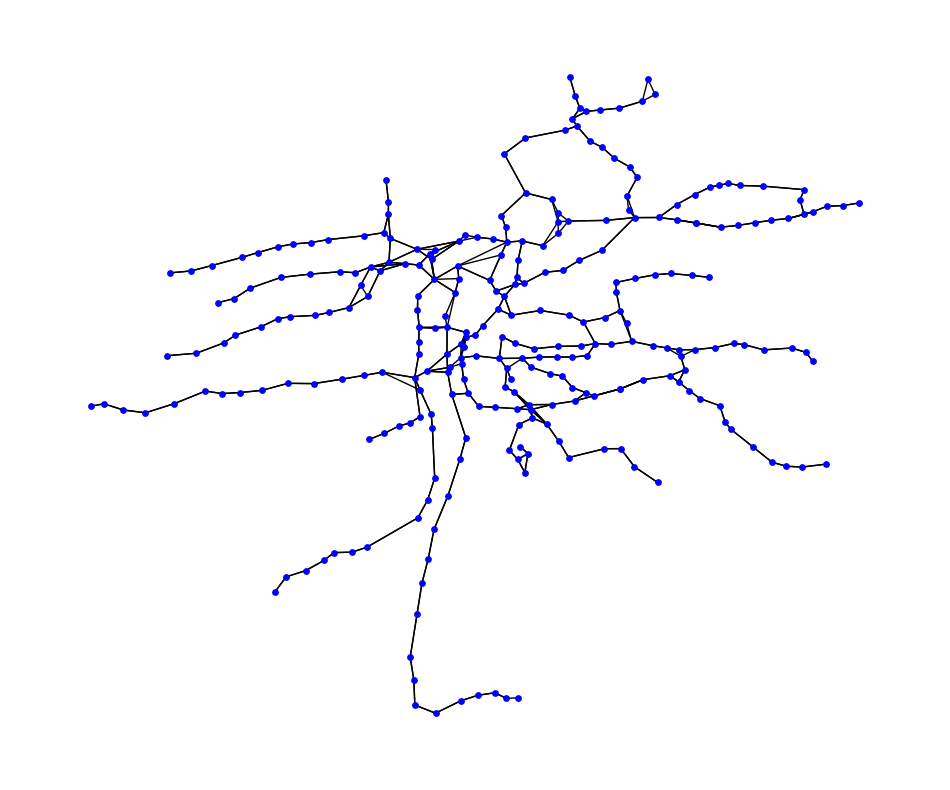

In [12]:
import matplotlib.pyplot as plt
graph = nx.DiGraph()

for _, row in unique_stops.iterrows():
    graph.add_node(row['stop_name'], pos=(row['stop_lon'], row['stop_lat']))

route_counts = tram_data.groupby(['stop_from_name', 'stop_to_name']).size()

for (stop_from_name, stop_to), count in route_counts.items():
    if stop_from_name in graph.nodes and stop_to in graph.nodes:
        graph.add_edge(stop_from_name, stop_to, weight=count)

fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.get_node_attributes(graph, 'pos')

nx.draw(
    graph,
    pos,
    with_labels=False,
    node_size=15,
    node_color='blue',
    edge_color='black',
    arrows=False
)

plt.show()

This visualization gives a clear overview of the tram network's structure and connectivity.

### 🗺️ Overlaying the tram network on a map of Prague
To validate the geographical accuracy of the tram network visualization, we overlay the graph on a basemap of Prague using the `contextily` library:

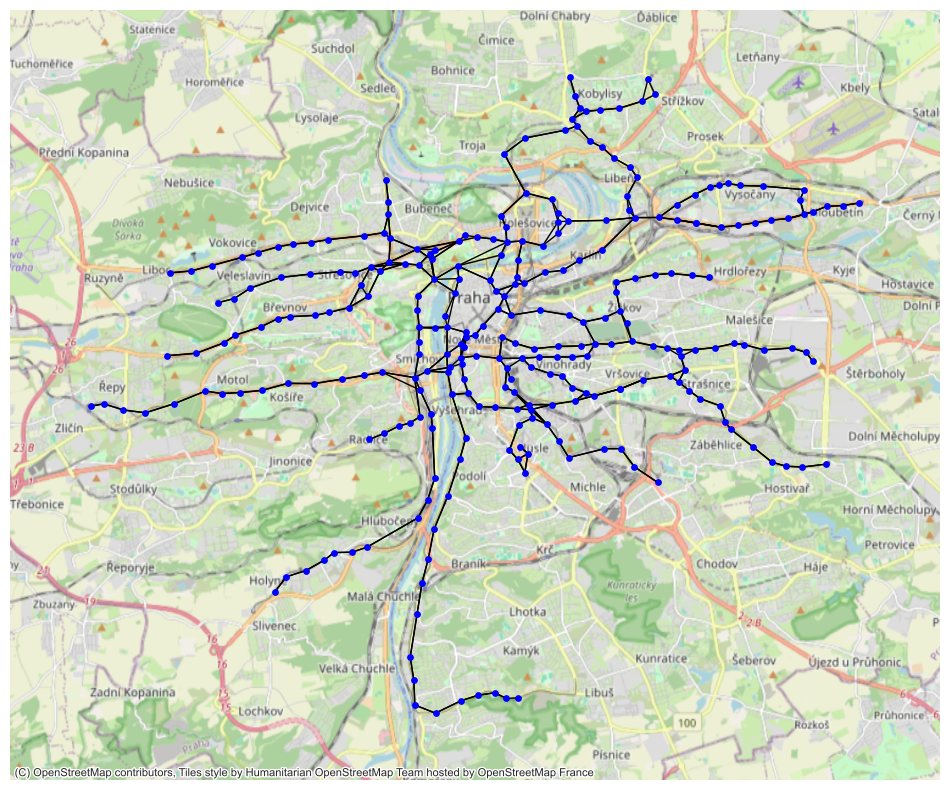

In [13]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(12, 10))
pos = nx.get_node_attributes(graph, 'pos')

x, y = zip(*pos.values())
x = list(x)  
y = list(y)  

nx.draw(
    graph,
    pos,
    with_labels=False,
    node_size=15,
    node_color='blue',
    edge_color='black',
    arrows=False,
    ax=ax
)

ctx.add_basemap(ax, crs="EPSG:4326") 

plt.show()

The visualization confirms geographical accuracy.

### 🛠️ Centrality analysis of tram stops
To analyze the importance of tram stops over a week (Monday–Sunday), we use **centrality measures**. The function `draw_graph_with_centrality` visualizes the graph with nodes colored according to their centrality values.

In [14]:
def draw_graph_with_centrality(graph, pos, centrality, centrality_name):
    plt.figure(figsize=(15, 15))
    color_map = sns.color_palette("flare", as_cmap=True)

    node_colors = []
    for node in graph.nodes:
        node_colors.append(centrality[node])
    nodes = nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=100,
        cmap=color_map,
        node_color=node_colors,
        nodelist=centrality.keys(),
    )
    norm = mcolors.SymLogNorm(linthresh=0.01, linscale=1)
    nodes.set_norm(norm)

    edges = nx.draw_networkx_edges(
        graph,
        pos=pos,
        edge_color='grey', 
        arrows=False  
    )
            
    node_positions = {}
    for node, coords in pos.items():
        node_positions[node] = (coords[0] + 0.0005, coords[1] + 0.0015)
    
    nx.draw_networkx_labels(
        graph, 
        node_positions,
        {}, 
        font_size=10, 
        font_color='black'
    )

    plt.axis('off')
    plt.title(centrality_name, fontsize=20)
    plt.colorbar(nodes)
    plt.show()

### 🛠️ Centrality Measures and Visualization
Here we calculate three centrality measures to analyze the importance of tram stops in the network and visualize their results:

1. **Degree Centrality**:
   - Measures the number of direct connections a node has.
   - Nodes with higher degree centrality are major hubs with many direct links to other stops.
   - Visualization highlights the most connected stops in the tram network.

2. **Betweenness Centrality**:
   - Quantifies how often a node lies on the shortest paths between other nodes.
   - Stops with high betweenness centrality are key intermediaries, often acting as transfer points in the network.
   - Visualization identifies critical stops for connectivity.

3. **Katz Centrality**:
   - Extends eigenvector centrality by considering the influence of distant nodes with an exponential decay factor (`alpha=0.1`).
   - Nodes with high Katz centrality are not only well-connected but also influenced by other well-connected nodes.
   - Visualization emphasizes nodes with both local and global importance.

**Visualization**:
- For each centrality measure, the graph is drawn with nodes colored based on their centrality values.
- The title of each visualization corresponds to the centrality measure, providing clear insights into the network's structure and stop importance.

In [15]:
degree_centrality = nx.degree_centrality(graph)
betweenness_centrality = nx.betweenness_centrality(graph, weight='weight')
katz_centrality = nx.katz_centrality(graph, alpha=0.1, beta=1.0)

pos = nx.get_node_attributes(graph, 'pos')

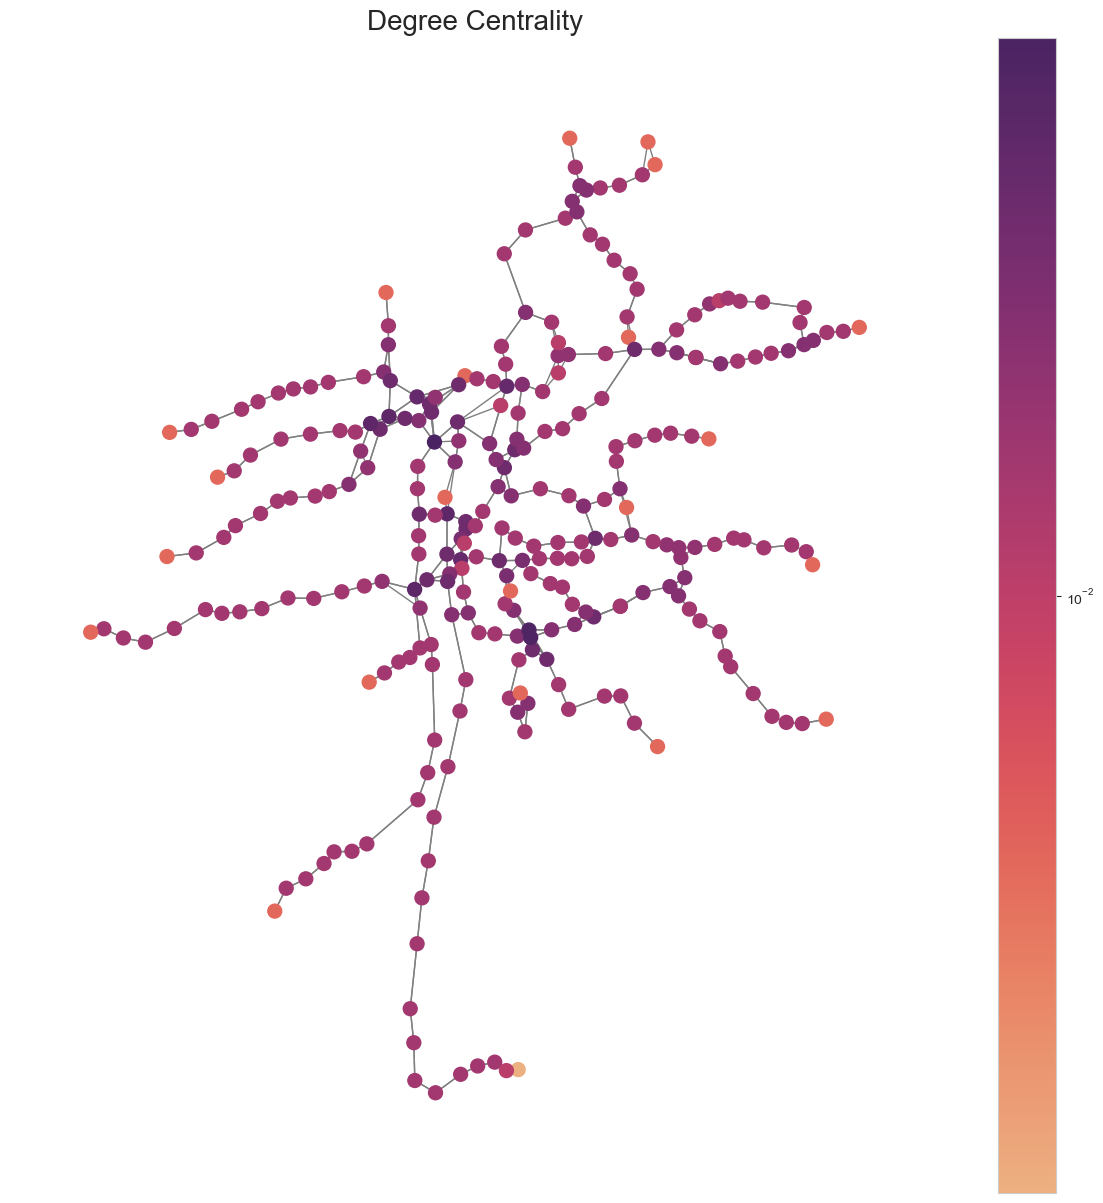

In [16]:
draw_graph_with_centrality(graph, pos, degree_centrality, 'Degree Centrality')

Stops with the highest degree centrality are located in the central part of the graph, which corresponds to key transfer nodes in the transport network.
Important nodes, such as Karlovo náměstí or Národní třída, are important centers, as main routes pass through them.
This metric shows the local importance of stops.

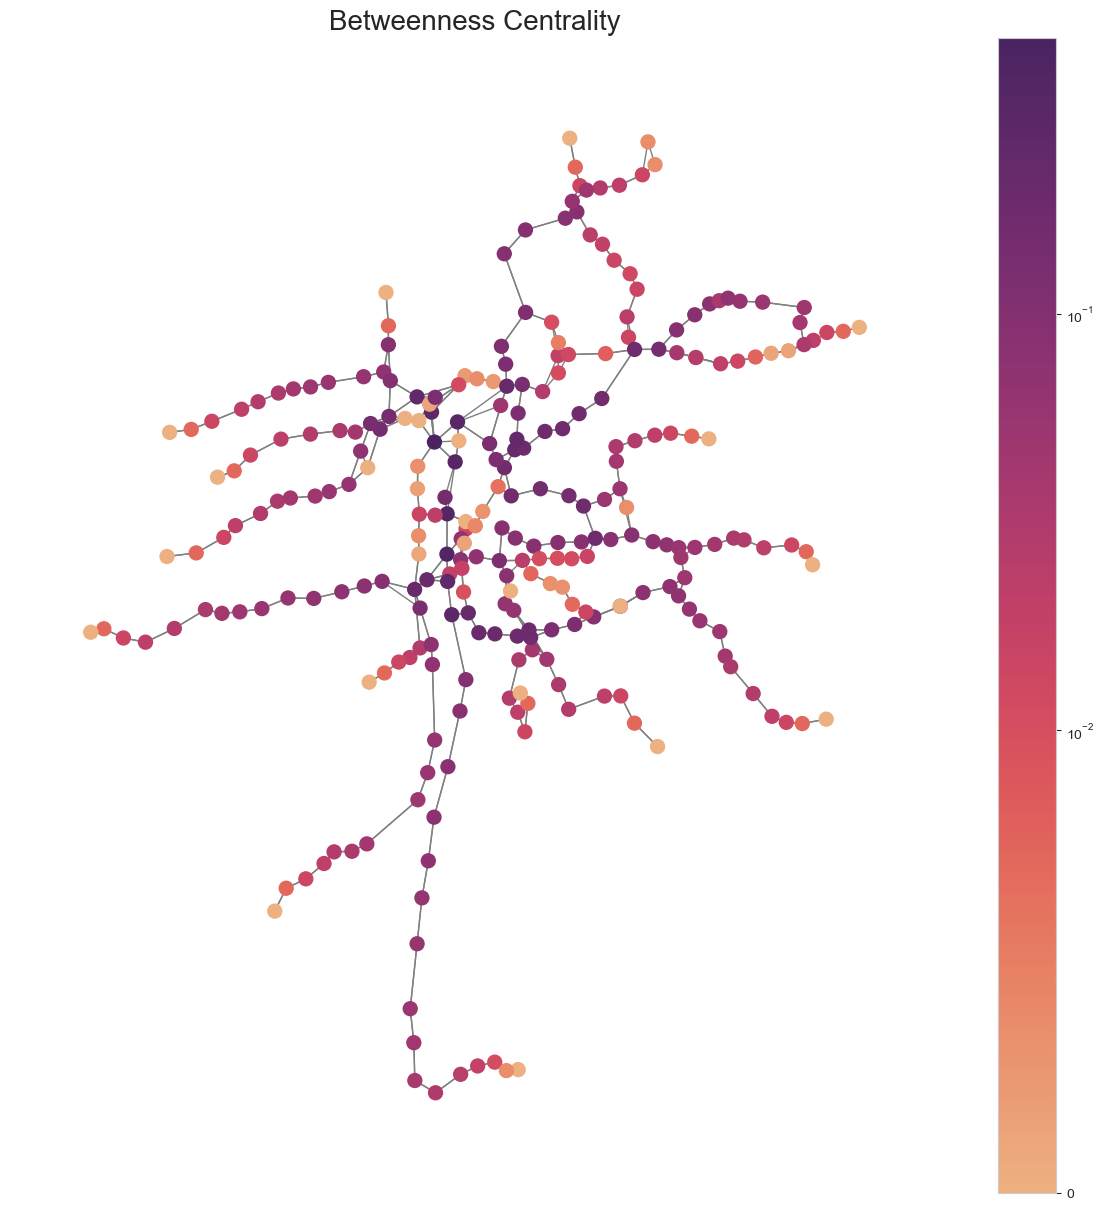

In [17]:
draw_graph_with_centrality(graph, pos, betweenness_centrality, 'Betweenness Centrality')

Nodes with high Betweenness Centrality, such as Národní třída, I. P. Pavlova, and Karlovo náměstí, play a key role in connecting different parts of the city.
This reflects their importance in providing connections between Prague's districts, especially at night.
Stops with high Betweenness Centrality are critical to the entire transport network.

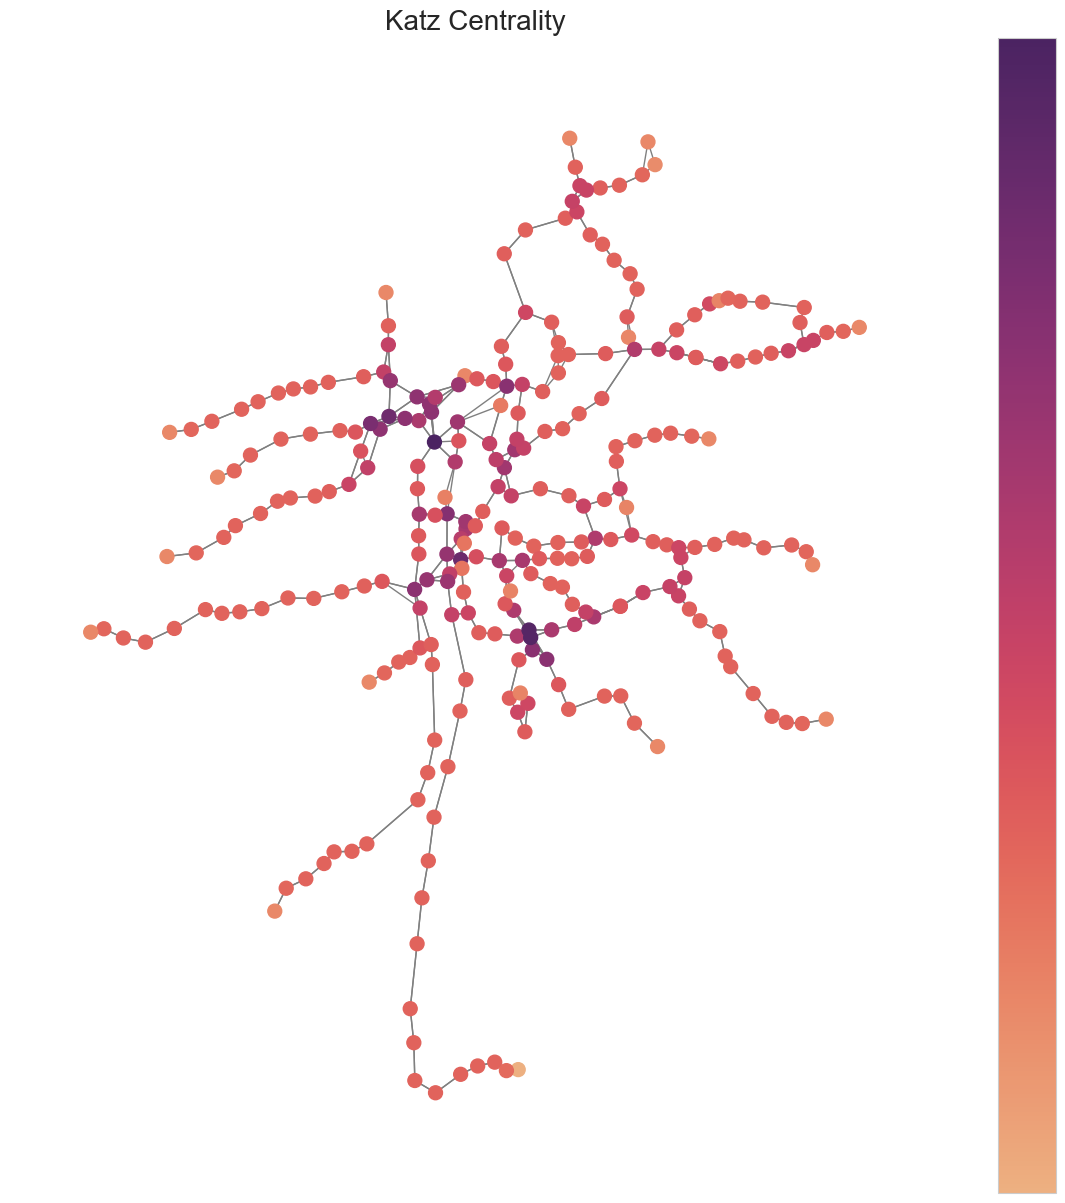

In [18]:
draw_graph_with_centrality(graph, pos, katz_centrality, 'Katz Centrality')

Stops such as Karlovo náměstí and I. P. Pavlova have high importance because they are not only connected to a large number of nodes, but also to important nodes.
This metric identifies key transport nodes that are important both locally and globally.

### ❓ Question 1: When are the peak tram hours for weekdays and weekends?

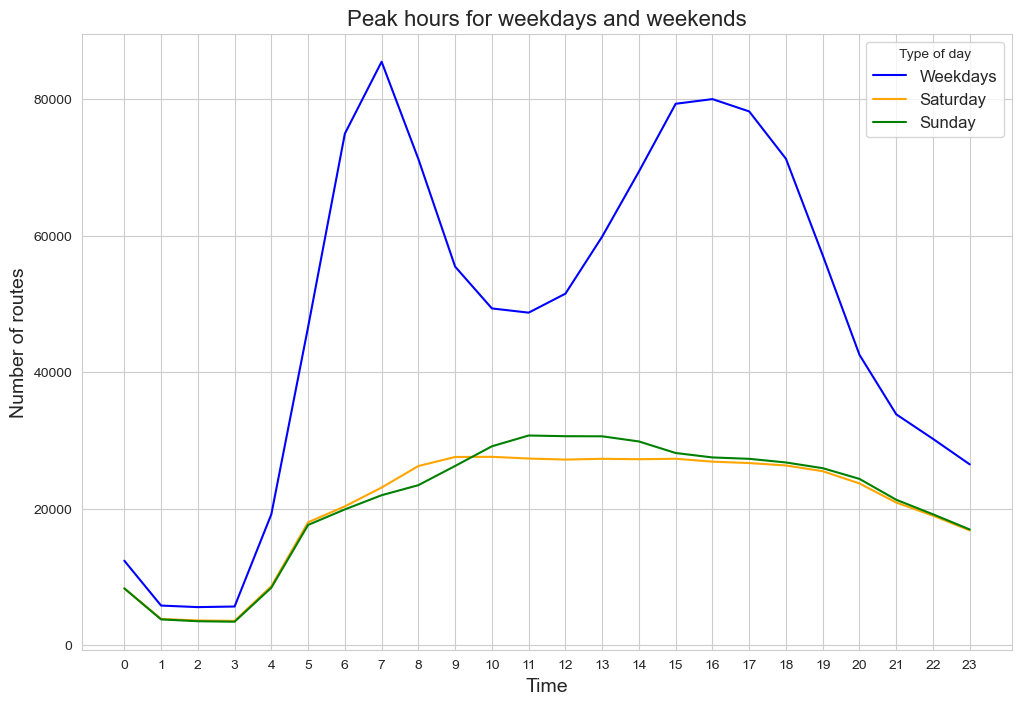

In [19]:
data['hour'] = data['depart_from'].apply(lambda x: x.hour)

data['weekday'] = data[['monday', 'tuesday', 'wednesday', 'thursday', 'friday']].sum(axis=1) / 5

hourly_activity = data.groupby('hour')[['weekday', 'saturday', 'sunday']].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(data=hourly_activity, x='hour', y='weekday', label='Weekdays', color='blue')
sns.lineplot(data=hourly_activity, x='hour', y='saturday', label='Saturday', color='orange')
sns.lineplot(data=hourly_activity, x='hour', y='sunday', label='Sunday', color='green')

plt.title('Peak hours for weekdays and weekends', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of routes', fontsize=14)
plt.legend(title='Type of day', fontsize=12)
plt.xticks(ticks=range(0, 24), labels=range(0, 24))
plt.grid(True)
plt.show()


- **Weekdays (blue)**: Clear peaks during commuting hours (7–9 AM and 4–6 PM), with low activity at night.
- **Saturday (orange)**: Activity is more evenly distributed, peaking mid-morning and evening.
- **Sunday (green)**: Lowest activity overall, with delayed and smaller peaks compared to other days.

This confirms that weekday schedules focus on commuting needs, while weekends show more consistent but lower usage throughout the day.

### ❓ Question 2: How does the usage of trams, buses, and the metro vary throughout the week?

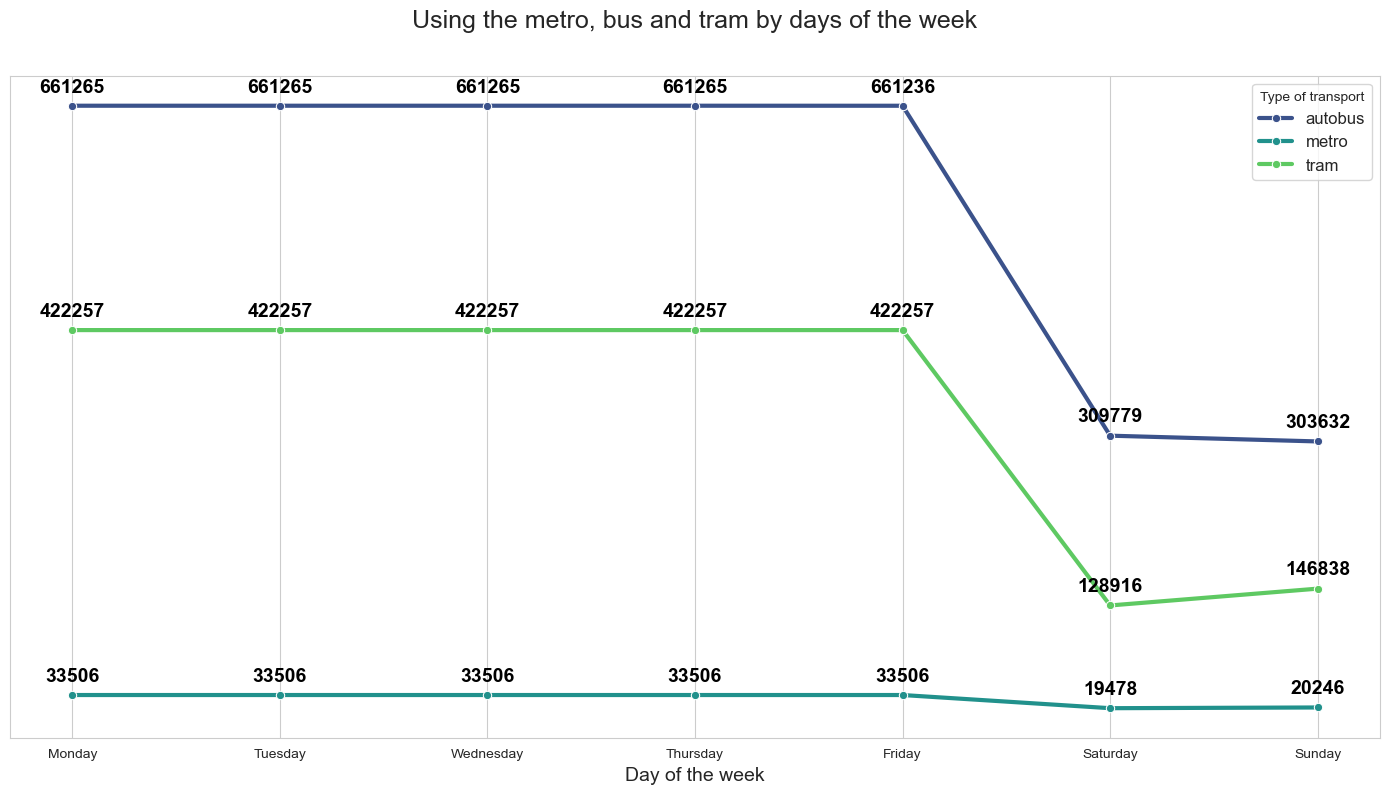

In [20]:
route_type_mapping = {
    0: 'tram',
    1: 'metro',
    3: 'autobus'
}

filtered_data = data[data['route_type'].isin(route_type_mapping.keys())].copy()

filtered_data.loc[:, 'transport_type'] = filtered_data['route_type'].map(route_type_mapping)

days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
usage_by_day = (
    filtered_data.melt(
        id_vars=['transport_type'], 
        value_vars=days, 
        var_name='day', 
        value_name='is_active'
    )
    .query('is_active == True')  
    .groupby(['day', 'transport_type'])
    .size()
    .reset_index(name='count') 
)

day_mapping = {
    'monday': 'Monday', 'tuesday': 'Tuesday', 'wednesday': 'Wednesday',
    'thursday': 'Thursday', 'friday': 'Friday', 'saturday': 'Saturday', 'sunday': 'Sunday'
}
usage_by_day['day'] = usage_by_day['day'].map(day_mapping)

usage_by_day['day'] = pd.Categorical(
    usage_by_day['day'], 
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    ordered=True
)

plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=usage_by_day, 
    x='day', 
    y='count', 
    hue='transport_type', 
    marker='o', 
    palette='viridis',
    linewidth=3
)

for line in usage_by_day.itertuples():
    ax.annotate(
        text=f"{int(line.count)}", 
        xy=(line.day, line.count), 
        xytext=(0, 10),  
        textcoords='offset points',
        ha='center', 
        fontsize=14,  
        color='black', 
        fontweight='bold'  
    )

plt.text(
    x=0.5, y=1.10, 
    s='Using the metro, bus and tram by days of the week', 
    fontsize=18, 
    ha='center', 
    va='top', 
    transform=plt.gca().transAxes
)
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('') 
plt.yticks([]) 
plt.legend(title='Type of transport', fontsize=12)
plt.tight_layout()
plt.show()


- **Buses**: High on weekdays, sharp drop on weekends.
- **Metro**: Consistent throughout the week.
- **Trams**: Stable on weekdays, lower on weekends.

Buses dominate weekday commuting, while metro and trams show steadier patterns.

### ❓ Question 3: Which stop pairs have the highest route flow?

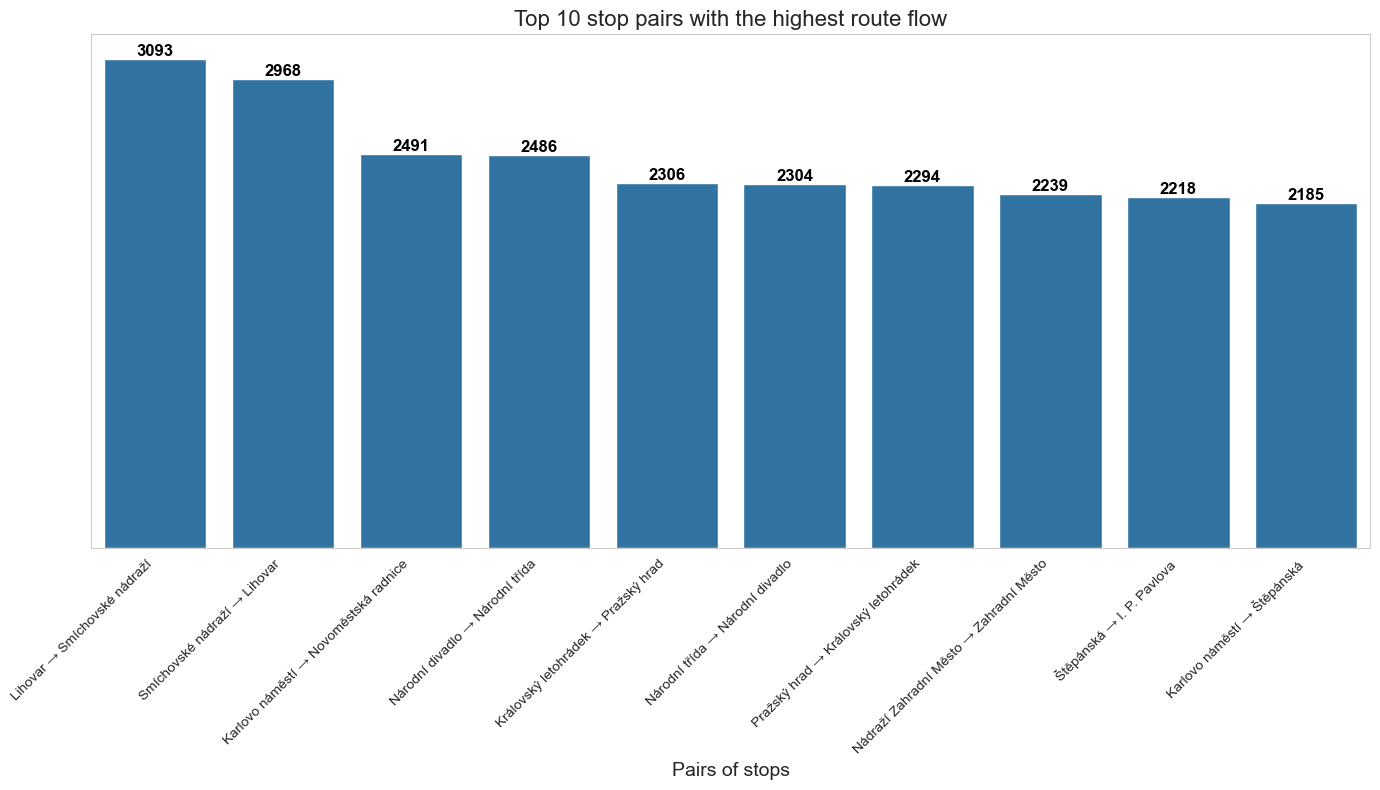

In [21]:
pair_flow = (
    data.groupby(['stop_from_name', 'stop_to_name'])
    .size()
    .reset_index(name='route_count')
    .sort_values(by='route_count', ascending=False)
)

top_pairs = pair_flow.head(10)
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=top_pairs, 
    y='route_count', 
    x=top_pairs['stop_from_name'] + ' → ' + top_pairs['stop_to_name'], 
    hue=None 
)

for bar in ax.patches:
    ax.annotate(
        format(bar.get_height(), '.0f'), 
        (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
        ha='center', 
        va='bottom', 
        fontsize=12, 
        color='black', 
        fontweight='bold'
    )

plt.title('Top 10 stop pairs with the highest route flow', fontsize=16)
plt.xlabel('Pairs of stops', fontsize=14)
plt.ylabel('')  
plt.yticks([])  
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


In [22]:
print(top_pairs)

               stop_from_name          stop_to_name  route_count
7199                  Lihovar    Smíchovské nádraží         3093
13220      Smíchovské nádraží               Lihovar         2968
4569          Karlovo náměstí   Novoměstská radnice         2491
10041         Národní divadlo         Národní třída         2486
6249     Královský letohrádek          Pražský hrad         2306
10051           Národní třída       Národní divadlo         2304
11496            Pražský hrad  Královský letohrádek         2294
9997   Nádraží Zahradní Město        Zahradní Město         2239
18209               Štěpánská         I. P. Pavlova         2218
4573          Karlovo náměstí             Štěpánská         2185
